In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date
%matplotlib inline

### 加载特大事故数据

In [2]:
df = pd.read_excel(r'D:\paper\safety\data\max_accident_data\accident_type.xlsx')
data = df.copy().drop('Unnamed: 6',axis =1)
data.columns = ['time','province','city','accident','death','injury']
data.head()

,time,province,city,accident,death,injury
0,2005-01-05,山西,运城市平陆县境内平风线,翻车,12.0,12.0
1,2005-01-06,福建,莆田市同三线高速公路莆田灵川路段,车辆失控,28.0,19.0
2,2005-01-11,山西,临汾市襄汾县京安村襄浏花炮厂装配车间,爆炸,25.0,10.0
3,2005-01-12,河南,洛阳市宜阳县城关乡乔岩直井煤矿,瓦斯燃烧,10.0,17.0
4,2005-01-16,重庆,南川区南城街道办事处云华煤业有限公司,煤与瓦斯突出,12.0,NaN


In [3]:
#总事故量
len(data)

853

### 处理时间字段数据

In [4]:
#编写获取事故发生的年月日的函数

def get_year_month_day(df,time_col):
    
    '''Extract the year, month, and day of the time field data'''
    
    df['year'] = df[time_col].dt.year
    df['month'] = df[time_col].dt.month
    df['day'] = df[time_col].dt.day
    return df

In [5]:
get_year_month_day(data,'time').tail()

,time,province,city,accident,death,injury,year,month,day
848,2019-11-18,山西,晋中市平遥县,峰岩集团二亩沟矿瓦斯爆炸,15.0,NaN,2019,11,18
849,2019-11-26,云南,临沧市凤庆县,安石隧道掌子面突泥涌水,12.0,NaN,2019,11,26
850,2019-12-03,浙江,海宁市许村镇工业园,龙洲印染有限责任公司污水厌氧罐倒塌,10.0,NaN,2019,12,3
851,2019-12-04,湖南,浏阳市,澄潭江镇碧溪烟花制造有限公司违法生产致爆炸,13.0,NaN,2019,12,4
852,2019-12-17,贵州,安龙县,广隆煤矿煤与瓦斯突出,14.0,NaN,2019,12,17


### 加载中国2005-2019年节假日和加班的情况
* ① 加载节假日的数据
* ② 加载加班的数据

In [6]:
#① 加载节假日的数据
holidays = pd.read_excel(r'D:\paper\safety\data\holidays.xlsx',usecols=['日期','节假日'])
holidays.tail()

,日期,节假日
410,2019-10-03,国庆节
411,2019-10-04,国庆节
412,2019-10-05,国庆节
413,2019-10-06,国庆节
414,2019-10-07,国庆节


In [7]:
#将时间数据转化为可用的数据格式
holidays_date = [holidays.loc[i,'日期'].date() for i in range(len(holidays))]
holidays_date[-5:]

[datetime.date(2019, 10, 3),
 datetime.date(2019, 10, 4),
 datetime.date(2019, 10, 5),
 datetime.date(2019, 10, 6),
 datetime.date(2019, 10, 7)]

In [8]:
#② 加载加班的数据
add_work = pd.read_excel(r'D:\paper\safety\data\add_work.xlsx',usecols=['日期','节假日'])
add_work.tail()

,日期,节假日
90,2019-02-03,春节
91,2019-04-28,劳动节
92,2019-05-05,劳动节
93,2019-09-29,国庆节
94,2019-10-12,国庆节


In [9]:
#将时间数据转化为可用的数据格式
add_work_date = [add_work.loc[i,'日期'].date() for i in range(len(add_work))]
add_work_date[-5:]

[datetime.date(2019, 2, 3),
 datetime.date(2019, 4, 28),
 datetime.date(2019, 5, 5),
 datetime.date(2019, 9, 29),
 datetime.date(2019, 10, 12)]

## 判断事故发生的时间是否为休息日

In [10]:
def restday(year,month,day,holidays_date,add_work_date):
    is_holiday    = [None]*len(year)
    is_weekend = [None]*len(year)
    i=0
    for yy,mm,dd in zip(year,month,day):        
        is_weekend[i] = (date(yy,mm,dd) not in add_work_date) and (date(yy,mm,dd).isoweekday() in (6,7)) and (date(yy,mm,dd) not in holidays_date)
        is_holiday[i] = date(yy,mm,dd) in holidays_date 
        i+=1
    return is_holiday,is_weekend

In [11]:
year,month,day = data.time.dt.year, data.time.dt.month, data.time.dt.day
holiday,weekend = restday(year,month,day,holidays_date,add_work_date)
data['holiday'] = holiday
data['weekend'] = weekend

In [12]:
data.head()
#证明是有在节假日和周末发生的事故

,time,province,city,accident,death,injury,year,month,day,holiday,weekend
0,2005-01-05,山西,运城市平陆县境内平风线,翻车,12.0,12.0,2005,1,5,False,False
1,2005-01-06,福建,莆田市同三线高速公路莆田灵川路段,车辆失控,28.0,19.0,2005,1,6,False,False
2,2005-01-11,山西,临汾市襄汾县京安村襄浏花炮厂装配车间,爆炸,25.0,10.0,2005,1,11,False,False
3,2005-01-12,河南,洛阳市宜阳县城关乡乔岩直井煤矿,瓦斯燃烧,10.0,17.0,2005,1,12,False,False
4,2005-01-16,重庆,南川区南城街道办事处云华煤业有限公司,煤与瓦斯突出,12.0,NaN,2005,1,16,False,True


## 添加节假日数据

In [13]:
data = pd.merge(data,holidays,left_on = 'time', right_on = '日期', how = 'left')
data.head()

,time,province,city,accident,death,injury,year,month,day,holiday,weekend,日期,节假日
0,2005-01-05,山西,运城市平陆县境内平风线,翻车,12.0,12.0,2005,1,5,False,False,NaT,NaN
1,2005-01-06,福建,莆田市同三线高速公路莆田灵川路段,车辆失控,28.0,19.0,2005,1,6,False,False,NaT,NaN
2,2005-01-11,山西,临汾市襄汾县京安村襄浏花炮厂装配车间,爆炸,25.0,10.0,2005,1,11,False,False,NaT,NaN
3,2005-01-12,河南,洛阳市宜阳县城关乡乔岩直井煤矿,瓦斯燃烧,10.0,17.0,2005,1,12,False,False,NaT,NaN
4,2005-01-16,重庆,南川区南城街道办事处云华煤业有限公司,煤与瓦斯突出,12.0,NaN,2005,1,16,False,True,NaT,NaN


In [14]:
#这时候就可以删除日期字段了(它的作用就是用来作为合并数据的依据)，
#有两个节假日信息，第一个英文的是是否为节假日，第二个是具体的节假日名称（这也是为什么这一列单独使用汉字的原因）
data.drop('日期',axis=1,inplace = True)

In [15]:
data

,time,province,city,accident,death,injury,year,month,day,holiday,weekend,节假日
0,2005-01-05,山西,运城市平陆县境内平风线,翻车,12.0,12.0,2005,1,5,False,False,NaN
1,2005-01-06,福建,莆田市同三线高速公路莆田灵川路段,车辆失控,28.0,19.0,2005,1,6,False,False,NaN
2,2005-01-11,山西,临汾市襄汾县京安村襄浏花炮厂装配车间,爆炸,25.0,10.0,2005,1,11,False,False,NaN
3,2005-01-12,河南,洛阳市宜阳县城关乡乔岩直井煤矿,瓦斯燃烧,10.0,17.0,2005,1,12,False,False,NaN
4,2005-01-16,重庆,南川区南城街道办事处云华煤业有限公司,煤与瓦斯突出,12.0,NaN,2005,1,16,False,True,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
848,2019-11-18,山西,晋中市平遥县,峰岩集团二亩沟矿瓦斯爆炸,15.0,NaN,2019,11,18,False,False,NaN
849,2019-11-26,云南,临沧市凤庆县,安石隧道掌子面突泥涌水,12.0,NaN,2019,11,26,False,False,NaN
850,2019-12-03,浙江,海宁市许村镇工业园,龙洲印染有限责任公司污水厌氧罐倒塌,10.0,NaN,2019,12,3,False,False,NaN
851,2019-12-04,湖南,浏阳市,澄潭江镇碧溪烟花制造有限公司违法生产致爆炸,13.0,NaN,2019,12,4,False,False,NaN


## 因调休周末上班发生的事故

In [16]:
data['weekend_work'] = data.apply(lambda x: date(x.year,x.month,x.day) in add_work_date, axis = 1)
print(len(data[data['weekend_work']== True]))
data[data['weekend_work']== True]

15


,time,province,city,accident,death,injury,year,month,day,holiday,weekend,节假日,weekend_work
38,2005-04-30,贵州,纳雍县鬃岭镇乡镇煤矿嫩草冲煤矿,瓦斯爆炸,12.0,NaN,2005,4,30,False,False,NaN,True
90,2005-10-08,浙江,湖州市开发区九九桥,坠河,22.0,NaN,2005,10,8,False,False,NaN,True
164,2006-04-29,陕西,延安市子长县瓦窑堡煤矿,瓦斯爆炸,27.0,5.0,2006,4,29,False,False,NaN,True
165,2006-04-30,陕西,镇安县米粮镇光明村山沟镇安黄金尾矿,溃坝,NaN,22.0,2006,4,30,False,False,NaN,True
199,2006-09-30,黑龙江,鸡西市鸡东县哈达天龙煤矿,瓦斯爆炸,13.0,NaN,2006,9,30,False,False,NaN,True
306,2007-12-29,黑龙江,牡丹江市穆棱市顺发煤矿,瓦斯,1.0,20.0,2007,12,29,False,False,NaN,True
317,2008-02-03,福建,宁德市远洋渔业集团公司,沉船,NaN,12.0,2008,2,3,False,False,NaN,True
405,2009-02-01,内蒙古,赤峰市喀喇沁旗王爷府镇团结地村路段一交乂道口,相撞,10.0,9.0,2009,2,1,False,False,NaN,True
538,2010-10-09,江苏,南京市浦口区宁合高速公路454km+100m处,槽罐大客相撞,17.0,6.0,2010,10,9,False,False,NaN,True
570,2011-04-02,新疆,乌鲁木齐市焦煤集团主焦煤分公司艾维尔沟煤矿,发生冒顶,10.0,NaN,2011,4,2,False,False,NaN,True


## 周末和及假日的重大事故情况

In [17]:
#周末的事故情况（正常的假期间）
data.weekend.value_counts()

False    629
True     224
Name: weekend, dtype: int64

In [18]:
#节假日的事故情况
data.holiday.value_counts()

#至此就可以发现工作日与非工作日之间的事故比例

False    789
True      64
Name: holiday, dtype: int64

## 正常工作日事故次数
* 正常工作日事故次数为：总事故数 - 节假日事故数 - 周末休息日事故数 - 调休周末上班日事故数

In [19]:
853 - 64 - 224 - 15

550

In [20]:
15/ 853 * 100

1.7584994138335288

## 结果

#### ①各时段的事故数量及占比

* 节假日发生事故起数： 64  事故占比为： 7.50%
* 正常周末休息发生的事故起数为： 224     事故占比为： 26.26%
* 因节假日调休周末上班发生的事故起数为： 15   事故占比为： 1.76%
* 正常上班发生的事故起数为： 853 - 64 - 224 - 15 = 550  事故占比为： 64.48%

#### ② 工作日与非工作日事故占比

* 工作日特大事故占比： (550 + 15) / 853 = 66.24%
* 非工作日特大事故占比： (224 + 64) / 853 = 33.76%

#### ③ 事故率计算

按照一年是365天，我国实际节假日是虽然从05年到18年有所变动（实际的有效假日变化不大），有效工作提250天，剩下的就是休息日115天
2007年往后将五一长假缩短，添加了端午和中秋（实际有效假日几乎没有发生变化），然后15年增加一个胜利日（这一年是增加一天假）

* 平均事故率： 853 / (365*15) = 15.56%
* 工作日平均事故率    (550 + 15) / (250*15) = 15.07%
* 非工作日平均事故率  (224 + 64) /(115*15) =  16.70%

In [21]:
853 / (365*15)

0.15579908675799087

In [22]:
(550 + 15) / (250*15)

0.15066666666666667

In [23]:
(224 + 64) /(115*15)

0.16695652173913045

### “十一五”至“十三五”期间的对比

In [24]:
len(data)
#总数还是853

853

In [25]:
data_11_5 = data[data['year'] < 2010]
data_12_5 = data[(2010 <= data['year']) & (data['year']< 2015)]
data_13_5 = data[2015 <= data['year']]
print('十一五的事故数量：{}'.format(len(data_11_5)))
print('十二五的事故数量：{}'.format(len(data_12_5)))
print('十三五的事故数量：{}'.format(len(data_13_5)))

十一五的事故数量：473
十二五的事故数量：263
十三五的事故数量：117


#### 先看十一五的情况

In [26]:
print(len(data_11_5[data_11_5['weekend_work']== True]))
data_11_5[data_11_5['weekend_work']== True]
#因调休周末上班发生的事故：8

8


,time,province,city,accident,death,injury,year,month,day,holiday,weekend,节假日,weekend_work
38,2005-04-30,贵州,纳雍县鬃岭镇乡镇煤矿嫩草冲煤矿,瓦斯爆炸,12.0,NaN,2005,4,30,False,False,NaN,True
90,2005-10-08,浙江,湖州市开发区九九桥,坠河,22.0,NaN,2005,10,8,False,False,NaN,True
164,2006-04-29,陕西,延安市子长县瓦窑堡煤矿,瓦斯爆炸,27.0,5.0,2006,4,29,False,False,NaN,True
165,2006-04-30,陕西,镇安县米粮镇光明村山沟镇安黄金尾矿,溃坝,NaN,22.0,2006,4,30,False,False,NaN,True
199,2006-09-30,黑龙江,鸡西市鸡东县哈达天龙煤矿,瓦斯爆炸,13.0,NaN,2006,9,30,False,False,NaN,True
306,2007-12-29,黑龙江,牡丹江市穆棱市顺发煤矿,瓦斯,1.0,20.0,2007,12,29,False,False,NaN,True
317,2008-02-03,福建,宁德市远洋渔业集团公司,沉船,NaN,12.0,2008,2,3,False,False,NaN,True
405,2009-02-01,内蒙古,赤峰市喀喇沁旗王爷府镇团结地村路段一交乂道口,相撞,10.0,9.0,2009,2,1,False,False,NaN,True


In [27]:
#周末的事故情况（正常的假期间）
data_11_5.weekend.value_counts()

False    355
True     118
Name: weekend, dtype: int64

In [28]:
#节假日的事故情况
data_11_5.holiday.value_counts()

#至此就可以发现工作日与非工作日之间的事故比例

False    436
True      37
Name: holiday, dtype: int64

In [29]:
# 正常工作日事故次数 
473 - 118 - 37 - 8

310

### “十一五”安全生产特大事故情况

#### ①各时段的事故数量及占比

* 节假日发生事故起数： 37  事故占比为： 7.82%
* 正常周末休息发生的事故起数为： 118    事故占比为： 24.95%
* 因节假日调休周末上班发生的事故起数为： 8   事故占比为： 1.69%
* 正常上班发生的事故起数为： 473 - 118 - 37 - 8= 310  事故占比为： 65.54%

#### ② 工作日与非工作日事故占比

* 工作日特大事故占比： (310 + 8) / 473 = 67.23%
* 非工作日特大事故占比： (118 + 37) / 473 = 32.77%

#### ③ 事故率计算

按照一年是365天，我国实际节假日是虽然从05年到18年有所变动（实际的有效假日变化不大），有效工作提250天，剩下的就是休息日115天 2007年往后将五一长假缩短，添加了端午和中秋（实际有效假日几乎没有发生变化），然后15年增加一个胜利日（这一年是增加一天假）

* 平均事故率： 473 / (365*5) = 25.92%
* 工作日平均事故率 (310 + 8)  / (250*5) = 25.44%
* 非工作日平均事故率 (118 + 37)  /(115*5) = 26.96%

In [30]:
473 / (365*5)

0.25917808219178085

In [31]:
(310 + 8)  / (250*5)

0.2544

In [32]:
(118 + 37)  /(115*5)

0.26956521739130435

#### 再看十二五的情况

In [33]:
print(len(data_12_5[data_12_5['weekend_work']== True]))
data_12_5[data_12_5['weekend_work']== True]
#因调休周末上班发生的事故：5

5


,time,province,city,accident,death,injury,year,month,day,holiday,weekend,节假日,weekend_work
538,2010-10-09,江苏,南京市浦口区宁合高速公路454km+100m处,槽罐大客相撞,17.0,6.0,2010,10,9,False,False,NaN,True
570,2011-04-02,新疆,乌鲁木齐市焦煤集团主焦煤分公司艾维尔沟煤矿,发生冒顶,10.0,NaN,2011,4,2,False,False,NaN,True
607,2011-10-08,辽宁,大连市旅顺口区塔河湾蓝湾三期施工现场,发生模板坍塌,13.0,4.0,2011,10,8,False,False,NaN,True
627,2011-12-31,贵州,榕江县至兴华乡摆乔村约,面包翻下路坎,10.0,2.0,2011,12,31,False,False,NaN,True
644,2012-04-28,云南,临沧市云县,运输车翻车,11.0,9.0,2012,4,28,False,False,NaN,True


In [34]:
#周末的事故情况（正常的假期间）
data_12_5.weekend.value_counts()

False    188
True      75
Name: weekend, dtype: int64

In [35]:
#节假日的事故情况
data_12_5.holiday.value_counts()

#至此就可以发现工作日与非工作日之间的事故比例

False    242
True      21
Name: holiday, dtype: int64

In [36]:
# 正常工作日事故次数 
263 - 75 - 21 - 5

162

#### ①各时段的事故数量及占比
* 节假日发生事故起数： 21 事故占比为： 7.98%
* 正常周末休息发生的事故起数为： 75 事故占比为： 28.75%
* 因节假日调休周末上班发生的事故起数为： 5 事故占比为： 1.90%
* 正常上班发生的事故起数为： 263 - 75 - 21 - 5 - 8= 162 事故占比为： 61.60%

#### ② 工作日与非工作日事故占比
* 工作日特大事故占比： (162 + 5) / 263 = 63.50%
* 非工作日特大事故占比： (75 + 21) / 263 = 36.50%

#### ③ 事故率计算
按照一年是365天，我国实际节假日是虽然从05年到18年有所变动（实际的有效假日变化不大），有效工作提250天，剩下的就是休息日115天 2007年往后将五一长假缩短，添加了端午和中秋（实际有效假日几乎没有发生变化），然后15年增加一个胜利日（这一年是增加一天假）

* 平均事故率： 263 / (365*5) = 14.41%
* 工作日平均事故率 (162 + 5) / (250*5) = 13.36%
* 非工作日平均事故率 (75 + 21) /(115*5) = 16.70%

In [37]:
263 / (365*5) *100

14.410958904109588

In [38]:
(162 + 5) / (250*5) * 100

13.36

In [39]:
(75 + 21) /(115*5) *100

16.695652173913047

### 最后看十三五的情况

In [40]:
print(len(data_13_5[data_13_5['weekend_work']== True]))
data_13_5[data_13_5['weekend_work']== True]
#因调休周末上班发生的事故：2

2


,time,province,city,accident,death,injury,year,month,day,holiday,weekend,节假日,weekend_work
753,2015-10-10,安徽,芜湖市镜湖区,小吃店发生火灾事故,17.0,NaN,2015,10,10,False,False,NaN,True
846,2019-09-29,浙江,宁海县梅林街道,宁波锐奇日用品公司起火,19.0,NaN,2019,9,29,False,False,NaN,True


In [41]:
#周末的事故情况（正常的假期间）
data_13_5.weekend.value_counts()

False    86
True     31
Name: weekend, dtype: int64

In [42]:
#节假日的事故情况
data_13_5.holiday.value_counts()

#至此就可以发现工作日与非工作日之间的事故比例

False    111
True       6
Name: holiday, dtype: int64

In [43]:
# 正常工作日事故次数 
117 - 31 - 6 - 2

78

#### ①各时段的事故数量及占比
* 节假日发生事故起数： 6 事故占比为： 5.13%
* 正常周末休息发生的事故起数为： 31 事故占比为： 26.50%
* 因节假日调休周末上班发生的事故起数为： 2 事故占比为： 1.71%
* 正常上班发生的事故起数为： 117 - 31 - 6 - 2 = 78 事故占比为： 66.67%

#### ② 工作日与非工作日事故占比
* 工作日特大事故占比： (78 + 2) / 117 = 68.38%
* 非工作日特大事故占比： (31 + 6) / 117 = 31.62%

#### ③ 事故率计算
按照一年是365天，我国实际节假日是虽然从05年到19年有所变动（实际的有效假日变化不大），有效工作提250天，剩下的就是休息日115天 2007年往后将五一长假缩短，添加了端午和中秋（实际有效假日几乎没有发生变化），然后15年增加一个胜利日（这一年是增加一天假）

* 平均事故率： 116 / (365*5) = 6.41%
* 工作日平均事故率 (78 + 2) / (250*5) = 6.40%
* 非工作日平均事故率 (31 + 6) /(115*5) = 6.43%

In [85]:
6/117

0.05128205128205128

In [44]:
78 / 117 *100

66.66666666666666

In [45]:
(78 + 2) / 117 * 100

68.37606837606837

In [46]:
(31 + 6) / 117 * 100

31.62393162393162

In [47]:
117 / (365*5) *100

6.410958904109589

In [48]:
(78 + 2) / (250*5) * 100

6.4

In [49]:
(31 + 6) /(115*5) * 100

6.434782608695652

### 绘制变化图

In [82]:
#数据为绝对指标
data_finnal = pd.DataFrame({"2005-2009":[37,118,8,310],
                            "2010-2014":[21,75,5,162],
                           "2015-2019":[6,31,2,78],
                           "2005-2019":[64,224,15,550]},index = ['节假日','周末','调休加班','上班'])
data_finnal

,2005-2009,2010-2014,2015-2019,2005-2019
节假日,37,21,6,64
周末,118,75,31,224
调休加班,8,5,2,15
上班,310,162,78,550


In [96]:
def percentage_bar(df):
    labels = df.index.tolist() #提取分类显示标签
    results = df.to_dict(orient = 'list') #将数值结果转化为字典
    category_names = list(results.keys()) # 提取字典里面的类别（键-key）
    data = np.array(list(results.values())) #提取字典里面的数值（值-value）

    category_colors = plt.get_cmap('Blues')(np.linspace(0.15, 0.85, data.shape[0])) 
    #设置占比显示的颜色，可以自定义，修改括号里面的参数即可，如下
    #category_colors = plt.get_cmap('hot')(np.linspace(0.15, 0.85, data.shape[0]))

    fig, ax = plt.subplots(figsize=(12, 9)) #创建画布，开始绘图
    ax.invert_xaxis()#这个可以通过设置df中columns的顺序调整
    ax.yaxis.set_visible(False) #设置y轴刻度不可见
    ax.set_xticklabels(labels=labels, rotation=90) #显示x轴标签，并旋转90度
    ax.set_ylim(0,1) #设置y轴的显示范围
    starts = 0  #绘制基准
    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        heights = data[i,: ]/ data.sum(axis =0) #计算出每次遍历时候的百分比
        ax.bar(labels, heights, bottom=starts, width=0.5,label=colname, color=color,edgecolor ='black') # 绘制柱状图
        xcenters = starts + heights/2  #进行文本标记位置的选定
        starts += heights  #核心一步，就是基于基准上的百分比累加
        #print(starts) 这个变量就是能否百分比显示的关键，可以打印输出看一下
        percentage_text = data[i,: ]/ data.sum(axis =0) #文本标记的数据
        
        r, g, b, _ = color  # 这里进行像素的分割
        text_color = 'white' if r * g * b < 0.5 else 'k'  #根据颜色基调分配文本标记的颜色
        for y, (x, c) in enumerate(zip(xcenters, percentage_text)):
            print(c,data.sum(axis =0)[y],c*data.sum(axis =0)[y])
            num = "{:.0f}".format(c*data.sum(axis =0)[y])
            ax.text(y, x, f'{round(c*100,2)}%({num})', ha='center', va='center',
                    color=text_color, rotation = 0) #添加文本标记
    ax.legend(ncol=len(category_names), bbox_to_anchor=(-0.1, 1,1,0.1),
              loc='upper', fontsize='xx-large') #设置图例
    return fig, ax  

0.07502930832356389 853 63.99999999999999
0.05128205128205128 117 6.0
0.07984790874524715 263 21.0
0.07822410147991543 473 37.0
0.26260257913247365 853 224.00000000000003
0.26495726495726496 117 31.0
0.28517110266159695 263 75.0
0.24947145877378435 473 118.0
0.017584994138335287 853 15.0
0.017094017094017096 117 2.0
0.019011406844106463 263 5.0
0.016913319238900635 473 8.0
0.6447831184056272 853 550.0
0.6666666666666666 117 78.0
0.6159695817490495 263 162.0
0.6553911205073996 473 310.0


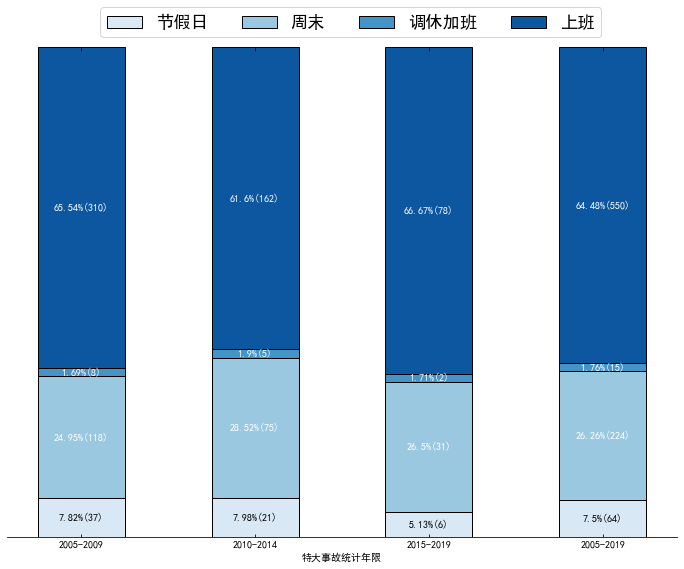

In [97]:
percentage_bar(data_finnal[data_finnal.columns[::-1]].T)
plt.xticks(rotation = 0)
ax = plt.gca()
ax.spines['top'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.grid(False)
plt.xlabel('特大事故统计年限')
plt.savefig(r'D:\paper\safety\max_accident_img\percentage_rate.png',dpi =200)

In [53]:
#再看相对指标
data_1 = pd.DataFrame({"2005-2009":[25.92,25.44,26.96],
                       "2010-2014":[14.41,13.36,16.70],
                       "2015-2019":[6.41,6.40,6.43],
                      "2005-2019":[15.56,15.07,16.70]},
                      index = ["平均事故率/%","工作日平均事故率/%","非工作日平均事故率/%"])
data_1

,2005-2009,2010-2014,2015-2019,2005-2019
平均事故率/%,25.92,14.41,6.41,15.56
工作日平均事故率/%,25.44,13.36,6.40,15.07
非工作日平均事故率/%,26.96,16.70,6.43,16.70


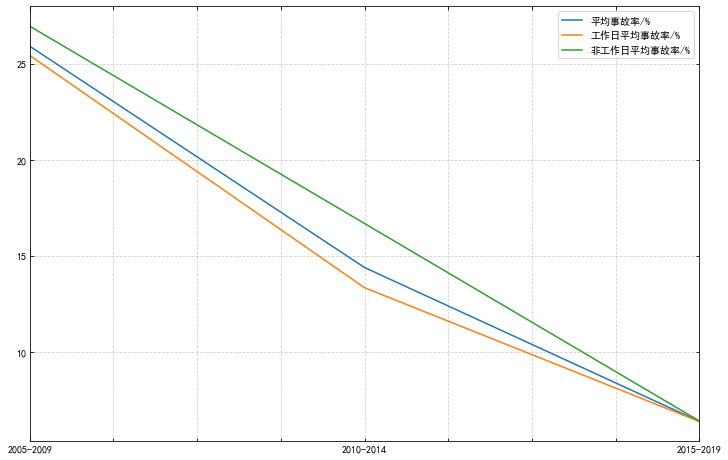

In [54]:
data_1[data_1.columns[:-1]].T.plot(figsize = (12,8))

### 具体的是有哪些节假日容易发生事故呢？

In [55]:
data['节假日'].value_counts()

国庆节    23
劳动节    14
春节     13
清明节     5
端午节     5
中秋节     2
元旦      2
Name: 节假日, dtype: int64

In [56]:
#查看某一节假日的事故，比如国庆节
data[data['节假日'].isin(['国庆节'])]

,time,province,city,accident,death,injury,year,month,day,holiday,weekend,节假日,weekend_work
85,2005-10-03,河南,鹤壁市煤业集团二矿 38 煤柱工作面采空区,瓦斯爆炸,34.0,19.0,2005,10,3,True,False,国庆节,False
86,2005-10-04,四川,广安市广安区境内四川煤炭产业集团公司所属广能集团龙滩煤矿,透水,28.0,NaN,2005,10,4,True,False,国庆节,False
87,2005-10-04,新疆,拜城县亚吐尔乡煤矿 1 号井,瓦斯爆炸,14.0,NaN,2005,10,4,True,False,国庆节,False
88,2005-10-04,广西,田林县境内田林县利周乡,坠沟,11.0,29.0,2005,10,4,True,False,国庆节,False
89,2005-10-04,甘肃,陇南市成县化垭乡开往县城成康路,坠崖,15.0,27.0,2005,10,4,True,False,国庆节,False
200,2006-10-01,重庆,沙坪坝区嘉陵江石门大桥引桥,坠桥,30.0,20.0,2006,10,1,True,False,国庆节,False
201,2006-10-05,新疆,库车县314 国道,追尾,10.0,3.0,2006,10,5,True,False,国庆节,False
202,2006-10-06,四川,宜宾市芙蓉煤矿,瓦斯爆炸,13.0,7.0,2006,10,6,True,False,国庆节,False
280,2007-10-01,湖南,常德市桃源县,翻车,11.0,NaN,2007,10,1,True,False,国庆节,False
281,2007-10-03,辽宁,丹东市大东港以南45海里处,撞沉,1.0,10.0,2007,10,3,True,False,国庆节,False


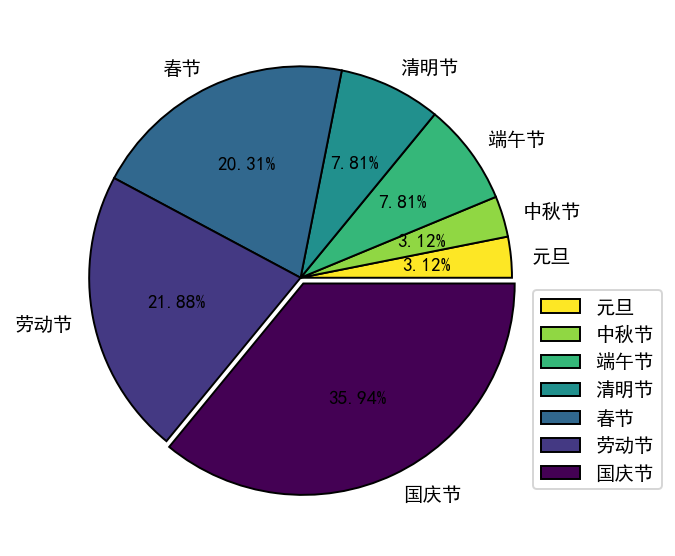

In [57]:
#绘制节假日事故饼图
plt.rcParams['figure.dpi'] = 140
data['节假日'].value_counts()[::-1].plot(kind='pie',autopct='%.2f%%',cmap='viridis_r',label = True,
                                wedgeprops={'linewidth': 1, 'edgecolor': "black"},
                                figsize=(10,5),
                               explode = [0,0,0,0,0,0,0.03])
plt.axis('off')
plt.legend(loc = (0.94,0.1))
plt.savefig(r'D:\paper\safety\max_accident_img\hosdays.png',dpi =200)